In [3]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import json
import pandas as pd
import latexify as lt

import warnings
warnings.filterwarnings("ignore")

import librosa
import librosa.display


from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;
import os

In [5]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [4]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


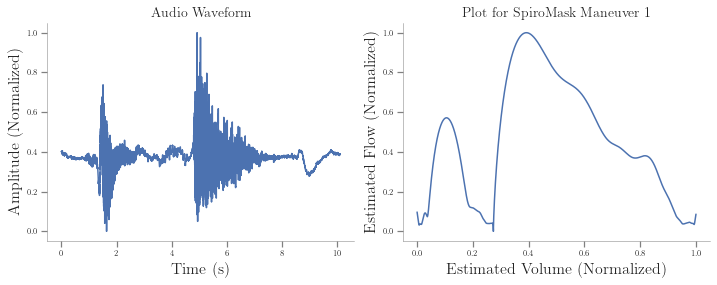

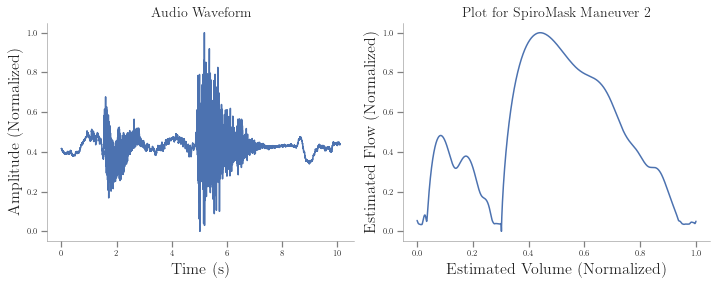

<Figure size 496.8x307.039 with 0 Axes>

In [4]:

lt.latexify(columns=2)    
mypath="uCdata/"
(_, _, filenames) = next(os.walk(mypath))
names = [file.split('.')[0] for file in filenames]

acceptable = ['SpiroMask Maneuver 1.wav','SpiroMask Maneuver 2.wav']

envelope_info_list_spiromask = []


for file in filenames:
    if file in acceptable:
        fig,ax = plt.subplots(1,2,figsize=(10,4))
        x, fs = librosa.load(mypath+file, sr=16000)
        t = np.arange(0,len(x))/fs
        cutoff_low = 50 # desired cutoff frequency of the filter, Hz
        cutoff_high = 1500
        order = 4

        #x_filt = butter_highpass_filter(x, cutoff, fs, order)
        x_filt = butter_bandpass_filter(x,cutoff_low,cutoff_high,fs,order)
        x_filt_hilbert = signal.hilbert(x_filt)
        envelope_hat = np.abs(x_filt_hilbert)
        #filter the Hilbert envelope
        nyq_rate = fs /0.5
        width = 1.0/nyq_rate # 5 Hz filter transition width.
        ripple_db = 10.0 # stop band attenuation
        fL_hz = 10
        N, beta = signal.kaiserord(ripple_db, width)
        taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
        envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
        t = np.arange(0,len(envelope_hat_filt))/fs

        #at this point we have the 
        #scale the envelope is estimate of flow rate. We will scale this to match actual flow range
        envelope_hat_filt = np.interp(envelope_hat_filt, (envelope_hat_filt.min(), 1), (0, 8))
        rPEF = round(envelope_hat_filt.max(),2)

        estdVolume = np.cumsum(envelope_hat_filt)
        estdVolume = np.interp(estdVolume, (0, np.cumsum([1]*len(t)).max()), (0, 8))
        #FEV1 Estimate
        rFEV1 = round(estdVolume[np.where(t==1)[0][0]],2)
        #FVC Estimate
        rFVC = round(estdVolume[-1],2)
        #print("FVC = {}".format(rFVC))

        rRatio = (rFEV1/rFVC)*100
        normalised_x = ((x-x.min())/(x.max()-x.min()))
        ax[0].plot(t,normalised_x)
        ax[0].set_xlabel('Time (s)', fontsize=16)
        ax[0].set_ylabel('Amplitude (Normalized)', fontsize=16)
        ax[0].set_title('Audio Waveform',fontsize=14)
        ax[0].grid(False)

        #0,1 normalisation
        envelope_hat_filt = ((envelope_hat_filt-envelope_hat_filt.min())/(envelope_hat_filt.max()-envelope_hat_filt.min()))
        estdVolume = ((estdVolume-estdVolume.min())/(estdVolume.max()-estdVolume.min()))

        ax[1].plot(estdVolume, envelope_hat_filt)
        #ax[1].set_ylim([0.4,0.8])
        ax[1].set_xlabel('Estimated Volume (Normalized)', fontsize=16)
        ax[1].set_ylabel('Estimated Flow (Normalized)', fontsize=16)
        ax[1].set_title('Plot for {}'.format(file.split('.')[0]),fontsize=14)
        ax[1].grid(False)

        envelope_info_list_spiromask.append(envelope_hat_filt)

        #S = librosa.feature.melspectrogram(y=x, sr=fs, n_mels=128,fmax=cutoff_high)
        #S_dB = librosa.power_to_db(S, ref=np.max)
        #img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=fs,fmax=cutoff_high, ax=ax[2])
        #fig.colorbar(img, ax=ax[2], format='%+2.0f dB')

        ax[0].set_facecolor("w")
        ax[1].set_facecolor("w")
        fig.tight_layout()
        lt.format_axes(ax[0])
        lt.format_axes(ax[1])

        plt.show()
        #break

plt.savefig('multi-maneuver-spiromask.pdf', bbox_inches='tight')

In [17]:
envelope_hat_filt.min()

0.5

In [64]:
envelope_info_list_spiromask = np.array(envelope_info_list_spiromask)
#np.save('spiromask-envelopes.npy', envelope_info_list_spiromask)

In [82]:
#measure dtw distance
skipT1 = 2
skipT2 = 2
distance, path = fastdtw(envelope_info_list_spiromask[1][::skipT1], envelope_info_list_spiromask[2][::skipT2], dist=euclidean)
print("Length of first time series is {} and the second is {}".format(len(envelope_info_list_spiromask[1][::skipT1]),len(envelope_info_list_spiromask[2][::skipT2])))
print("Distance = {}".format(distance))
#result_matrix = dtw(envelope_info_list[0][::20],envelope_info_list[1][::20])

Length of first time series is 80896 and the second is 80896
Distance = 131.06846914245085


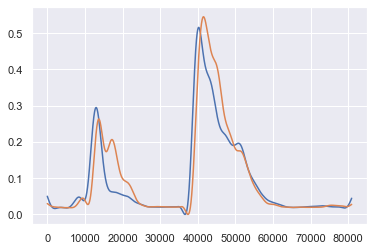

In [89]:
plt.plot(envelope_info_list_spiromask[1][::2])
plt.plot(envelope_info_list_spiromask[2][::2])
         

FVC = 1.63


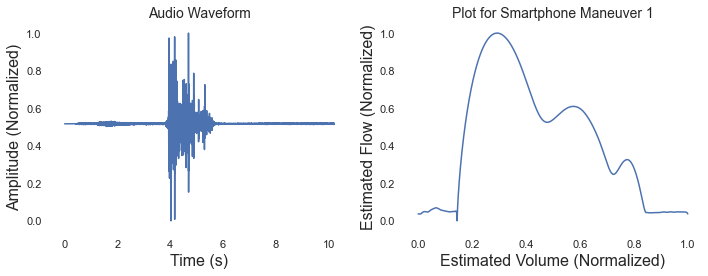

FVC = 1.08


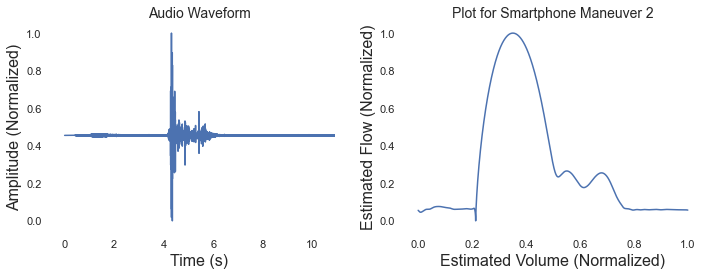

In [5]:
#phone data
    
mypath="phonedata/"
(_, _, filenames) = next(os.walk(mypath))
names = [file.split('.')[0] for file in filenames]

acceptable = ['Smartphone Maneuver 1.m4a','Smartphone Maneuver 2.m4a']

#arrray to store the HT envelope
envelope_info_list = []


for file in filenames:
    if file in acceptable:
        fig,ax = plt.subplots(1,2,figsize=(10,4))
        x, fs = librosa.load(mypath+file, sr=44100)
        t = np.arange(0,len(x))/fs
        cutoff_low = 50 # desired cutoff frequency of the filter, Hz
        cutoff_high = 1500
        order = 4

        #x_filt = butter_highpass_filter(x, cutoff, fs, order)
        x_filt = butter_bandpass_filter(x,cutoff_low,cutoff_high,fs,order)
        x_filt_hilbert = signal.hilbert(x_filt)
        envelope_hat = np.abs(x_filt_hilbert)
        #filter the Hilbert envelope
        nyq_rate = fs /0.5
        width = 1.0/nyq_rate # 5 Hz filter transition width.
        ripple_db = 10.0 # stop band attenuation
        fL_hz = 10
        N, beta = signal.kaiserord(ripple_db, width)
        taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
        envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
        t = np.arange(0,len(envelope_hat_filt))/fs

        #at this point we have the 
        #scale the envelope is estimate of flow rate. We will scale this to match actual flow range
        envelope_hat_filt = np.interp(envelope_hat_filt, (envelope_hat_filt.min(), 1), (0, 8))
        rPEF = round(envelope_hat_filt.max(),2)

        estdVolume = np.cumsum(envelope_hat_filt)
        estdVolume = np.interp(estdVolume, (0, np.cumsum([1]*len(t)).max()), (0, 8))
        #FEV1 Estimate
        rFEV1 = round(estdVolume[np.where(t==1)[0][0]],2)
        #FVC Estimate
        rFVC = round(estdVolume[-1],2)
        print("FVC = {}".format(rFVC))

        rRatio = (rFEV1/rFVC)*100

        normalised_x = ((x-x.min())/(x.max()-x.min()))
        ax[0].plot(t,normalised_x)
        ax[0].set_xlabel('Time (s)', fontsize=16)
        ax[0].set_ylabel('Amplitude (Normalized)', fontsize=16)
        ax[0].set_title('Audio Waveform',fontsize=14)
        ax[0].grid(False)


        #0,1 normalisation
        envelope_hat_filt = ((envelope_hat_filt-envelope_hat_filt.min())/(envelope_hat_filt.max()-envelope_hat_filt.min()))
        estdVolume = ((estdVolume-estdVolume.min())/(estdVolume.max()-estdVolume.min()))

        ax[1].plot(estdVolume, envelope_hat_filt)
        ax[1].set_xlabel('Estimated Volume (Normalized)', fontsize=16)
        ax[1].set_ylabel('Estimated Flow (Normalized)', fontsize=16)
        ax[1].set_title('Plot for {}'.format(file.split('.')[0]), fontsize=14)
        ax[1].grid(False)

        envelope_info_list.append(envelope_hat_filt)


        #S = librosa.feature.melspectrogram(y=x, sr=fs, n_mels=128,fmax=cutoff_high)
        #S_dB = librosa.power_to_db(S, ref=np.max)
        #img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=fs,fmax=cutoff_high, ax=ax[2])
        #fig.colorbar(img, ax=ax[2], format='%+2.0f dB')

        ax[0].set_facecolor("w")
        ax[1].set_facecolor("w")
        fig.tight_layout()

        plt.show()
        #break


## Spectogram For _SpiroMask_

Number of sample in audio = 161792
Number of frames = 629.0
Number of frequency components in a frame = 513.0
Number of sample in audio = 161792
Number of frames = 629.0
Number of frequency components in a frame = 513.0


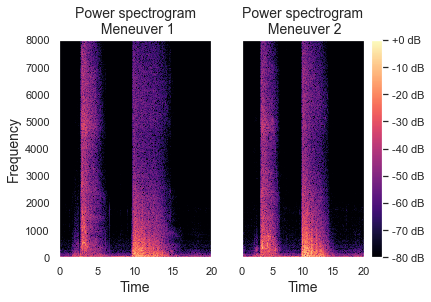

In [14]:
#lt.latexify(columns=1)
mypath="uCdata/"
(_, _, filenames) = next(os.walk(mypath))
names = [file.split('.')[0] for file in filenames]

acceptable = ['SpiroMask Maneuver 1.wav','SpiroMask Maneuver 2.wav']
plotIndex = 0;
fig, ax = plt.subplots(1,2)

for i,file in enumerate(filenames):
    if file in acceptable:
        x, fs = librosa.load(mypath+file, sr=16000)
        t = np.arange(0,len(x))/fs
        
        n_fft = 1024
        hop_length = n_fft//4 #the default value in librosa 
        print("Number of sample in audio = {}".format(x.shape[0]))
        print("Number of frames = {}".format((x.shape[0]-n_fft)/hop_length+1))
        print("Number of frequency components in a frame = {}".format(n_fft/2+1))
        
        S = np.abs(librosa.stft(x,hop_length=hop_length,n_fft=n_fft))
        
        img = librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max),y_axis='linear', x_axis='time', ax=ax[plotIndex], sr=fs)
        ax[plotIndex].set_title('Power spectrogram\n Meneuver {}'.format(plotIndex+1),fontsize=14)
        ax[plotIndex].set_xlabel('Time',fontsize=14)
        ax[plotIndex].set_ylabel('Frequency',fontsize=14)
        ax[plotIndex].set_ylim(0,8000)
        ax[plotIndex].set_xlim(0,20)
        if plotIndex == 1:
            ax[plotIndex].tick_params(which='both',axis='y',left=False, labelleft=False)
            fig.colorbar(img, ax=ax[plotIndex], format="%+2.0f dB")
            ax[plotIndex].get_yaxis().set_visible(False)
        #lt.format_axes(ax[plotIndex])
        plotIndex+=1;
        
#fig.tight_layout()
#plt.show()
plt.savefig('multi-maneuver-spiromask-spectrogram.pdf', bbox_inches='tight')

## Spectogram For _Smartphone Spirometry_

Number of sample in audio = 450560
Number of frames = 1757.0
Number of frequency components in a frame = 513.0
Number of sample in audio = 480256
Number of frames = 1873.0
Number of frequency components in a frame = 513.0


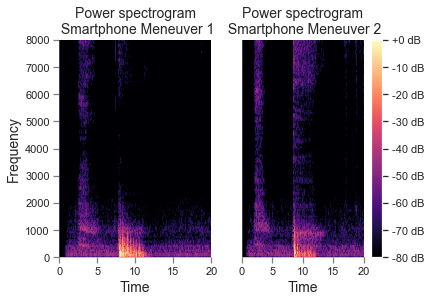

In [13]:
#lt.latexify(columns=1)
mypath="phonedata/"
(_, _, filenames) = next(os.walk(mypath))
names = [file.split('.')[0] for file in filenames]

acceptable = ['Smartphone Maneuver 1.m4a','Smartphone Maneuver 2.m4a']
plotIndex = 0;
fig, ax = plt.subplots(1,2)

for i,file in enumerate(filenames):
    if file in acceptable:
        x, fs = librosa.load(mypath+file, sr=44100)
        t = np.arange(0,len(x))/fs
        
        n_fft = 1024
        hop_length = n_fft//4 #the default value in librosa 
        print("Number of sample in audio = {}".format(x.shape[0]))
        print("Number of frames = {}".format((x.shape[0]-n_fft)/hop_length+1))
        print("Number of frequency components in a frame = {}".format(n_fft/2+1))
        
        S = np.abs(librosa.stft(x,hop_length=hop_length,n_fft=n_fft))
        
        img = librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max),y_axis='linear', x_axis='time', ax=ax[plotIndex], sr=fs)
        ax[plotIndex].set_title('Power spectrogram\n Smartphone Meneuver {}'.format(plotIndex+1),fontsize=14)
        ax[plotIndex].set_xlabel('Time',fontsize=14)
        ax[plotIndex].set_ylabel('Frequency',fontsize=14)
        ax[plotIndex].set_ylim(0,8000)
        ax[plotIndex].set_xlim(0,20)
        if plotIndex == 1:
            ax[plotIndex].tick_params(which='both',axis='y',left=False, labelleft=False)
            fig.colorbar(img, ax=ax[plotIndex], format="%+2.0f dB")
            ax[plotIndex].get_yaxis().set_visible(False)
        lt.format_axes(ax[plotIndex])
        plotIndex+=1;
        
#fig.tight_layout()
#plt.show()
plt.savefig('multi-maneuver-smartphone-spectrogram.pdf', bbox_inches='tight')

## Generate Plots For Manuscript

### SpiroMask

FVC = 1535.78
FVC = 1665.37


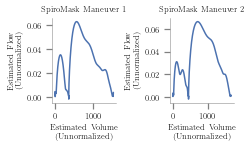

In [7]:

lt.latexify(columns=1)    
mypath="uCdata/"
(_, _, filenames) = next(os.walk(mypath))
names = [file.split('.')[0] for file in filenames]

acceptable = ['SpiroMask Maneuver 1.wav','SpiroMask Maneuver 2.wav']

plotIndex = 0;

envelope_info_list_spiromask = []
fig,ax = plt.subplots(1,2)

for i,file in enumerate(filenames):
    if file in acceptable:
        x, fs = librosa.load(mypath+file, sr=16000)
        t = np.arange(0,len(x))/fs
        cutoff_low = 50 # desired cutoff frequency of the filter, Hz
        cutoff_high = 1500
        order = 4

        #x_filt = butter_highpass_filter(x, cutoff, fs, order)
        x_filt = butter_bandpass_filter(x,cutoff_low,cutoff_high,fs,order)
        x_filt_hilbert = signal.hilbert(x_filt)
        envelope_hat = np.abs(x_filt_hilbert)
        #filter the Hilbert envelope
        nyq_rate = fs /0.5
        width = 1.0/nyq_rate # 5 Hz filter transition width.
        ripple_db = 10.0 # stop band attenuation
        fL_hz = 10
        N, beta = signal.kaiserord(ripple_db, width)
        taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
        envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
        t = np.arange(0,len(envelope_hat_filt))/fs

        #at this point we have the 
        #scale the envelope is estimate of flow rate. We will scale this to match actual flow range
        #envelope_hat_filt = np.interp(envelope_hat_filt, (envelope_hat_filt.min(), 1), (0, 8))
        rPEF = round(envelope_hat_filt.max(),2)

        estdVolume = np.cumsum(envelope_hat_filt)
        #estdVolume = np.interp(estdVolume, (0, np.cumsum([1]*len(t)).max()), (0, 8))
        #FEV1 Estimate
        rFEV1 = round(estdVolume[np.where(t==1)[0][0]],2)
        #FVC Estimate
        rFVC = round(estdVolume[-1],2)
        print("FVC = {}".format(rFVC))

        rRatio = (rFEV1/rFVC)*100
        normalised_x = ((x-x.min())/(x.max()-x.min()))
        #ax[0].plot(t,normalised_x)
        #ax[0].set_xlabel('Time (s)', fontsize=16)
        #ax[0].set_ylabel('Amplitude (Normalized)', fontsize=16)
        #ax[0].set_title('Audio Waveform',fontsize=14)
        #ax[0].grid(False)

        #0,1 normalisation
        #envelope_hat_filt = ((envelope_hat_filt-envelope_hat_filt.min())/(envelope_hat_filt.max()-envelope_hat_filt.min()))
        #estdVolume = ((estdVolume-estdVolume.min())/(estdVolume.max()-estdVolume.min()))
        
        #spectogram
        

        ax[plotIndex].plot(estdVolume, envelope_hat_filt)
        #ax[1].set_ylim([0.4,0.8])
        ax[plotIndex].set_xlabel('Estimated Volume\n (Unnormalized)')
        ax[plotIndex].set_ylabel('Estimated Flow\n (Unnormalized)')
        ax[plotIndex].set_title('{}'.format(file.split('.')[0]))
        ax[plotIndex].grid(False)

        envelope_info_list_spiromask.append(envelope_hat_filt)

        #S = librosa.feature.melspectrogram(y=x, sr=fs, n_mels=128,fmax=cutoff_high)
        #S_dB = librosa.power_to_db(S, ref=np.max)
        #img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=fs,fmax=cutoff_high, ax=ax[2])
        #fig.colorbar(img, ax=ax[2], format='%+2.0f dB')

        ax[plotIndex].set_facecolor("w")
        lt.format_axes(ax[plotIndex])
        plotIndex+=1
        
fig.tight_layout()
#plt.show()
plt.savefig('multi-maneuver-spiromask-unnormalised.pdf', bbox_inches='tight')

### Smartphone

FVC = 8186.7
FVC = 4618.96


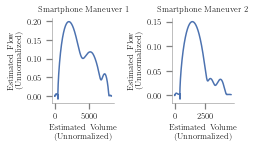

In [5]:
#phone data
lt.latexify(columns=1)     
mypath="phonedata/"
(_, _, filenames) = next(os.walk(mypath))
names = [file.split('.')[0] for file in filenames]

acceptable = ['Smartphone Maneuver 1.m4a','Smartphone Maneuver 2.m4a']
fig,ax = plt.subplots(1,2)
#arrray to store the HT envelope
envelope_info_list = []
plotIndex = 0;


for file in filenames:
    if file in acceptable:
        
        x, fs = librosa.load(mypath+file, sr=44100)
        t = np.arange(0,len(x))/fs
        cutoff_low = 50 # desired cutoff frequency of the filter, Hz
        cutoff_high = 1500
        order = 4

        #x_filt = butter_highpass_filter(x, cutoff, fs, order)
        x_filt = butter_bandpass_filter(x,cutoff_low,cutoff_high,fs,order)
        x_filt_hilbert = signal.hilbert(x_filt)
        envelope_hat = np.abs(x_filt_hilbert)
        #filter the Hilbert envelope
        nyq_rate = fs /0.5
        width = 1.0/nyq_rate # 5 Hz filter transition width.
        ripple_db = 10.0 # stop band attenuation
        fL_hz = 10
        N, beta = signal.kaiserord(ripple_db, width)
        taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
        envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
        t = np.arange(0,len(envelope_hat_filt))/fs

        #at this point we have the 
        #scale the envelope is estimate of flow rate. We will scale this to match actual flow range
        #envelope_hat_filt = np.interp(envelope_hat_filt, (envelope_hat_filt.min(), 1), (0, 8))
        rPEF = round(envelope_hat_filt.max(),2)

        estdVolume = np.cumsum(envelope_hat_filt)
        #estdVolume = np.interp(estdVolume, (0, np.cumsum([1]*len(t)).max()), (0, 8))
        #FEV1 Estimate
        rFEV1 = round(estdVolume[np.where(t==1)[0][0]],2)
        #FVC Estimate
        rFVC = round(estdVolume[-1],2)
        print("FVC = {}".format(rFVC))

        rRatio = (rFEV1/rFVC)*100

        normalised_x = ((x-x.min())/(x.max()-x.min()))
        #ax[0].plot(t,normalised_x)
        #ax[0].set_xlabel('Time (s)', fontsize=16)
        #ax[0].set_ylabel('Amplitude (Normalized)', fontsize=16)
        #ax[0].set_title('Audio Waveform',fontsize=14)
        #ax[0].grid(False)


        #0,1 normalisation
        #envelope_hat_filt = ((envelope_hat_filt-envelope_hat_filt.min())/(envelope_hat_filt.max()-envelope_hat_filt.min()))
        #estdVolume = ((estdVolume-estdVolume.min())/(estdVolume.max()-estdVolume.min()))

        ax[plotIndex].plot(estdVolume, envelope_hat_filt)
        ax[plotIndex].set_xlabel('Estimated Volume\n (Unnormalized)')
        ax[plotIndex].set_ylabel('Estimated Flow\n (Unnormalized)')
        ax[plotIndex].set_title('{}'.format(file.split('.')[0]))
        ax[plotIndex].grid(False)

        envelope_info_list.append(envelope_hat_filt)


        #S = librosa.feature.melspectrogram(y=x, sr=fs, n_mels=128,fmax=cutoff_high)
        #S_dB = librosa.power_to_db(S, ref=np.max)
        #img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=fs,fmax=cutoff_high, ax=ax[2])
        #fig.colorbar(img, ax=ax[2], format='%+2.0f dB')

        ax[plotIndex].set_facecolor("w")
        lt.format_axes(ax[plotIndex])
        plotIndex+=1

fig.tight_layout()
#plt.show()
plt.savefig('multi-maneuver-smartphone-unnormalised.pdf', bbox_inches='tight')